In [109]:
from cmr import GranuleQuery
import datetime
from shapely.geometry import box
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from osgeo import gdal
import rasterio
import concurrent.futures

# GDAL configs used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','FALSE')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

# Constants

In [85]:
HLS_S30_CONCEPT_ID = 'C2021957295-LPCLOUD'
HLS_L30_CONCEPT_ID = 'C2021957657-LPCLOUD'
DSWX_CONCEPT_ID = 'C2617126679-POCLOUD'

# Parameters

In [6]:
now = datetime.datetime.now()
delta = datetime.timedelta(days=7)

beg_date = now - delta
end_date = now

# DSWx Metadata

In [7]:
api = GranuleQuery()

In [10]:
q = api.concept_id(DSWX_CONCEPT_ID)
q = q.temporal(beg_date, end_date)

In [11]:
q.hits()

48374

In [22]:
# %%time

# dswx_metadata = q.get_all()

In [23]:
dswx_metadata[0]

{'producer_granule_id': 'OPERA_L3_DSWx-HLS_T18QZJ_20230502T150725Z_20230504T070106Z_L8_30_v1.0',
 'boxes': ['20.755 -72.119 21.767 -71.039'],
 'time_start': '2023-05-02T15:07:25.530Z',
 'updated': '2023-05-04T07:11:46.805Z',
 'dataset_id': 'OPERA Dynamic Surface Water Extent from Harmonized Landsat Sentinel-2 provisional product (Version 1)',
 'data_center': 'POCLOUD',
 'title': 'OPERA_L3_DSWx-HLS_T18QZJ_20230502T150725Z_20230504T070106Z_L8_30_v1.0',
 'coordinate_system': 'CARTESIAN',
 'day_night_flag': 'UNSPECIFIED',
 'time_end': '2023-05-02T15:07:25.530Z',
 'id': 'G2676595915-POCLOUD',
 'original_format': 'UMM_JSON',
 'granule_size': '0.029317855834960938',
 'browse_flag': True,
 'collection_concept_id': 'C2617126679-POCLOUD',
 'online_access_flag': True,
 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/browse#',
   'title': 'Download OPERA_L3_DSWx-HLS_T18QZJ_20230502T150725Z_20230504T070106Z_L8_30_v1.0_BROWSE.png',
   'hreflang': 'en-US',
   'href': 'https://archive.podaac.ea

## Formatting

In [78]:
def format_dswx(item):
    out = {}
    granule_id = item['producer_granule_id']
    out['granule_id'] = granule_id
    out['time_acquired'] = pd.to_datetime(item['time_start'])
    out['time_updated'] = pd.to_datetime(item['updated'])
    out['B01_WTR_link'] = next(link_data['href'] for link_data in item['links'] 
                           if all(kw in link_data['href'] for kw in ['B01_WTR', 'https://']))
    
    bbox_str = item['boxes'][0].split(' ')
    bbox_floats = [float(coord) for coord in bbox_str]
    out['time_acq_str'] = granule_id.split('_')[4]
    out['mgrs_tile_id'] = granule_id.split('_')[3]
    ymin, xmin, ymax, xmax = bbox_floats
    # Fix dateline issues
    if abs(xmax - xmin) > 180:
        xmin = min(xmax, xmin)
        xmax = max(xmax, xmin)
        xmax = xmax - 360
    out['geometry'] = box(xmin, ymin, xmax, ymax)
    return out

In [79]:
dswx_data_formatted = list(map(format_dswx, tqdm(dswx_metadata)))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 48400/48400 [00:25<00:00, 1865.85it/s]


In [80]:
df = gpd.GeoDataFrame(dswx_data_formatted)
df.head()

,granule_id,time_acquired,time_updated,B01_WTR_link,time_acq_str,mgrs_tile_id,geometry
0,OPERA_L3_DSWx-HLS_T18QZJ_20230502T150725Z_2023...,2023-05-02 15:07:25.530000+00:00,2023-05-04 07:11:46.805000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230502T150725Z,T18QZJ,"POLYGON ((-71.03900 20.75500, -71.03900 21.767..."
1,OPERA_L3_DSWx-HLS_T19QBD_20230502T150725Z_2023...,2023-05-02 15:07:25.530000+00:00,2023-05-04 07:12:13.563000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230502T150725Z,T19QBD,"POLYGON ((-70.82700 20.77600, -70.82700 21.782..."
2,OPERA_L3_DSWx-HLS_T18QZK_20230502T150725Z_2023...,2023-05-02 15:07:25.530000+00:00,2023-05-06 02:13:14.605000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230502T150725Z,T18QZK,"POLYGON ((-71.01400 21.65600, -71.01400 22.669..."
3,OPERA_L3_DSWx-HLS_T19QBE_20230502T150725Z_2023...,2023-05-02 15:07:25.530000+00:00,2023-05-06 02:13:20.682000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230502T150725Z,T19QBE,"POLYGON ((-70.83800 21.67800, -70.83800 22.685..."
4,OPERA_L3_DSWx-HLS_T20QKF_20230502T150719Z_2023...,2023-05-02 15:07:46.350000+00:00,2023-05-04 10:31:19.872000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230502T150719Z,T20QKF,"POLYGON ((-64.79700 18.06800, -64.79700 19.072..."


<Axes: >

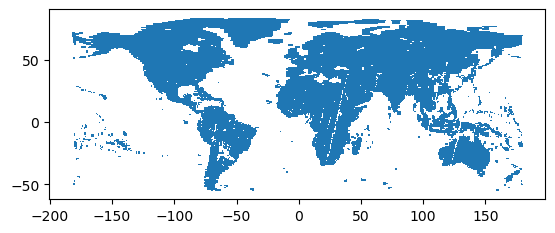

In [81]:
df.plot()

In [82]:
#df.to_file('dswx_metadata.geojson', driver='GeoJSON')

## Compute nodata pixels

In [104]:
def get_mask_data(url: str) -> dict:
    with rasterio.open(url) as ds:
        m = ~(ds.read_masks(1).astype(bool))
    total_nodata = m.sum()
    return {'total_nodata_pixels': total_nodata, 'percent_nodata': total_nodata / m.size * 100}

def get_mask_data_from_item(item: dict) -> dict:
    url = item['B01_WTR_link']
    return get_mask_data(url)

In [108]:
no_data_info = list(map(get_mask_data_from_item, tqdm(dswx_data_formatted[:4])))
no_data_info

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.38it/s]


[{'total_nodata_pixels': 5246246, 'percent_nodata': 0.39163949356505123},
 {'total_nodata_pixels': 2475207, 'percent_nodata': 0.18477761354474603},
 {'total_nodata_pixels': 7568438, 'percent_nodata': 0.5649943264952672},
 {'total_nodata_pixels': 5281986, 'percent_nodata': 0.3943075338170743}]

In [ ]:
n = len(dswx_data_formatted)
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    no_data_info = list(tqdm(executor.map(get_mask_data_from_item, dswx_data_formatted[:]), total=n))


  0%|▍                                                                                           | 233/48400 [00:42<5:41:58,  2.35it/s]


  1%|▋                                                                                           | 344/48400 [01:10<3:10:29,  4.20it/s]


  1%|▊                                                                                           | 452/48400 [01:38<2:42:38,  4.91it/s]


  1%|█                                                                                           | 567/48400 [02:09<3:36:25,  3.68it/s]


  1%|█▎                                                                                          | 672/48400 [02:37<3:54:42,  3.39it/s]


  2%|█▍                                                                                          | 779/48400 [03:07<4:31:11,  2.93it/s]


  2%|█▋                                                                                          | 883/48400 [03:34<3:17:35,  4.01it/s]


  2%|█▊                                                                                          | 973/48400 [03:58<3:10:48,  4.14it/s]


  2%|██                                                                                         | 1079/48400 [04:26<4:51:53,  2.70it/s]


  2%|██▎                                                                                        | 1202/48400 [04:57<4:08:42,  3.16it/s]


  3%|██▍                                                                                        | 1299/48400 [05:22<2:07:52,  6.14it/s]


  3%|██▋                                                                                        | 1422/48400 [05:56<5:36:55,  2.32it/s]


  3%|██▉                                                                                        | 1532/48400 [06:24<3:31:10,  3.70it/s]


  3%|███                                                                                        | 1621/48400 [06:47<2:46:05,  4.69it/s]


  4%|███▏                                                                                       | 1713/48400 [07:12<3:39:38,  3.54it/s]


  4%|███▍                                                                                       | 1818/48400 [07:40<3:19:23,  3.89it/s]


  4%|███▋                                                                                       | 1930/48400 [08:09<3:45:10,  3.44it/s]


  4%|███▊                                                                                       | 2014/48400 [08:31<3:22:49,  3.81it/s]


  4%|███▉                                                                                       | 2108/48400 [08:57<2:31:13,  5.10it/s]


  5%|████▏                                                                                      | 2205/48400 [09:22<3:42:55,  3.45it/s]


  5%|████▎                                                                                      | 2294/48400 [09:44<3:30:17,  3.65it/s]


  5%|████▍                                                                                      | 2385/48400 [10:07<3:20:09,  3.83it/s]


  5%|████▋                                                                                      | 2474/48400 [10:30<2:47:46,  4.56it/s]


  5%|████▊                                                                                      | 2568/48400 [10:54<3:10:48,  4.00it/s]


  6%|█████                                                                                      | 2676/48400 [11:22<3:02:17,  4.18it/s]


  6%|█████▎                                                                                     | 2803/48400 [11:54<2:26:26,  5.19it/s]


  6%|█████▍                                                                                     | 2920/48400 [12:24<3:22:59,  3.73it/s]


  6%|█████▋                                                                                     | 3028/48400 [12:51<3:15:09,  3.87it/s]


  6%|█████▉                                                                                     | 3135/48400 [13:20<3:21:27,  3.74it/s]


  7%|██████                                                                                     | 3239/48400 [13:47<3:09:17,  3.98it/s]


  7%|██████▎                                                                                    | 3334/48400 [14:11<2:49:22,  4.43it/s]


  7%|██████▍                                                                                    | 3428/48400 [14:35<3:26:49,  3.62it/s]


  7%|██████▋                                                                                    | 3527/48400 [15:02<4:04:00,  3.07it/s]


  8%|██████▊                                                                                    | 3635/48400 [15:31<3:27:46,  3.59it/s]


  8%|███████                                                                                    | 3733/48400 [15:57<2:28:30,  5.01it/s]


  8%|███████▏                                                                                   | 3834/48400 [16:25<2:49:29,  4.38it/s]


  8%|███████▍                                                                                   | 3928/48400 [16:49<3:14:40,  3.81it/s]


  8%|███████▌                                                                                   | 4027/48400 [17:14<3:01:17,  4.08it/s]


  9%|███████▊                                                                                   | 4133/48400 [17:41<2:49:29,  4.35it/s]


  9%|███████▉                                                                                   | 4237/48400 [18:09<5:20:37,  2.30it/s]


  9%|████████▏                                                                                  | 4330/48400 [18:33<3:01:12,  4.05it/s]


  9%|████████▎                                                                                  | 4420/48400 [18:56<2:52:22,  4.25it/s]


  9%|████████▌                                                                                  | 4533/48400 [19:25<5:08:12,  2.37it/s]


 10%|████████▋                                                                                  | 4646/48400 [19:54<2:10:27,  5.59it/s]


 10%|████████▉                                                                                  | 4736/48400 [20:17<2:44:26,  4.43it/s]


 10%|█████████                                                                                  | 4831/48400 [20:43<4:26:58,  2.72it/s]


 10%|█████████▎                                                                                 | 4938/48400 [21:09<2:45:11,  4.38it/s]


 10%|█████████▍                                                                                 | 5028/48400 [21:33<2:50:26,  4.24it/s]


 11%|█████████▋                                                                                 | 5148/48400 [22:04<1:55:23,  6.25it/s]


 11%|█████████▉                                                                                 | 5259/48400 [22:34<5:03:17,  2.37it/s]


 11%|██████████                                                                                 | 5359/48400 [23:00<2:34:15,  4.65it/s]


 11%|██████████▎                                                                                | 5465/48400 [23:29<2:41:57,  4.42it/s]


 11%|██████████▍                                                                                | 5565/48400 [23:56<3:26:58,  3.45it/s]


 12%|██████████▋                                                                                | 5663/48400 [24:21<2:33:51,  4.63it/s]


 12%|██████████▊                                                                                | 5750/48400 [24:44<5:46:01,  2.05it/s]


 12%|███████████                                                                                | 5873/48400 [25:15<2:15:03,  5.25it/s]


 12%|███████████▎                                                                               | 5984/48400 [25:43<2:18:53,  5.09it/s]


 13%|███████████▍                                                                               | 6104/48400 [26:15<4:09:03,  2.83it/s]


 13%|███████████▋                                                                               | 6204/48400 [26:39<3:35:15,  3.27it/s]


 13%|███████████▉                                                                               | 6323/48400 [27:11<3:15:31,  3.59it/s]


 13%|████████████                                                                               | 6422/48400 [27:37<2:59:24,  3.90it/s]


 13%|████████████▎                                                                              | 6528/48400 [28:08<4:00:18,  2.90it/s]


 14%|████████████▍                                                                              | 6648/48400 [28:39<3:44:36,  3.10it/s]


 14%|████████████▋                                                                              | 6762/48400 [29:07<2:42:03,  4.28it/s]


 14%|████████████▉                                                                              | 6879/48400 [29:37<3:50:51,  3.00it/s]


 14%|█████████████▏                                                                             | 6981/48400 [30:04<3:10:01,  3.63it/s]


 15%|█████████████▎                                                                             | 7102/48400 [30:35<3:15:07,  3.53it/s]


 15%|█████████████▌                                                                             | 7220/48400 [31:05<3:27:18,  3.31it/s]


 15%|█████████████▊                                                                             | 7329/48400 [31:32<2:49:54,  4.03it/s]


 15%|██████████████                                                                             | 7449/48400 [32:05<3:29:46,  3.25it/s]


 16%|██████████████▏                                                                            | 7571/48400 [32:37<3:29:54,  3.24it/s]


 16%|██████████████▍                                                                            | 7679/48400 [33:08<2:47:28,  4.05it/s]


 16%|██████████████▋                                                                            | 7793/48400 [33:40<4:25:57,  2.54it/s]


 16%|██████████████▊                                                                            | 7887/48400 [34:05<2:42:34,  4.15it/s]


 16%|███████████████                                                                            | 7984/48400 [34:30<3:04:03,  3.66it/s]


 17%|███████████████▏                                                                           | 8079/48400 [34:54<2:21:06,  4.76it/s]


 17%|███████████████▍                                                                           | 8200/48400 [35:25<2:22:17,  4.71it/s]


 17%|███████████████▋                                                                           | 8312/48400 [35:53<2:14:43,  4.96it/s]


 17%|███████████████▊                                                                           | 8412/48400 [36:19<3:24:12,  3.26it/s]


 18%|████████████████                                                                           | 8526/48400 [36:48<3:10:08,  3.50it/s]


 18%|████████████████▏                                                                          | 8632/48400 [37:15<3:12:07,  3.45it/s]


 18%|████████████████▍                                                                          | 8728/48400 [37:39<3:41:43,  2.98it/s]


 18%|████████████████▌                                                                          | 8821/48400 [38:02<2:54:02,  3.79it/s]


 18%|████████████████▊                                                                          | 8919/48400 [38:28<2:20:04,  4.70it/s]


 19%|████████████████▉                                                                          | 9030/48400 [38:56<2:15:18,  4.85it/s]


 19%|█████████████████▏                                                                         | 9124/48400 [39:21<3:01:52,  3.60it/s]


 19%|█████████████████▎                                                                         | 9216/48400 [39:44<2:34:26,  4.23it/s]


 19%|█████████████████▌                                                                         | 9329/48400 [40:13<2:40:42,  4.05it/s]


 20%|█████████████████▊                                                                         | 9446/48400 [40:42<2:55:39,  3.70it/s]


 20%|█████████████████▉                                                                         | 9547/48400 [41:07<2:47:22,  3.87it/s]


 20%|██████████████████▏                                                                        | 9667/48400 [41:41<4:05:17,  2.63it/s]


 20%|██████████████████▎                                                                        | 9766/48400 [42:07<3:12:40,  3.34it/s]


 20%|██████████████████▌                                                                        | 9874/48400 [42:34<2:04:53,  5.14it/s]


 21%|██████████████████▋                                                                        | 9969/48400 [42:59<3:56:31,  2.71it/s]


 21%|██████████████████▊                                                                       | 10098/48400 [43:31<2:56:06,  3.62it/s]


 21%|██████████████████▉                                                                       | 10210/48400 [44:01<2:53:58,  3.66it/s]


 21%|███████████████████▏                                                                      | 10305/48400 [44:27<3:31:07,  3.01it/s]


 22%|███████████████████▎                                                                      | 10407/48400 [44:52<3:50:50,  2.74it/s]


 22%|███████████████████▌                                                                      | 10529/48400 [45:23<3:01:20,  3.48it/s]


 22%|███████████████████▊                                                                      | 10638/48400 [45:50<3:42:09,  2.83it/s]


 22%|███████████████████▉                                                                      | 10755/48400 [46:20<2:32:45,  4.11it/s]


 22%|████████████████████▏                                                                     | 10850/48400 [46:45<3:12:29,  3.25it/s]


 23%|████████████████████▎                                                                     | 10951/48400 [47:11<3:00:13,  3.46it/s]


 23%|████████████████████▌                                                                     | 11043/48400 [47:34<2:42:29,  3.83it/s]


 23%|████████████████████▋                                                                     | 11130/48400 [47:56<2:07:59,  4.85it/s]


 23%|████████████████████▊                                                                     | 11225/48400 [48:21<3:16:17,  3.16it/s]


 23%|█████████████████████                                                                     | 11341/48400 [48:49<2:06:10,  4.90it/s]


 24%|█████████████████████▎                                                                    | 11435/48400 [49:12<2:33:07,  4.02it/s]


 24%|█████████████████████▍                                                                    | 11523/48400 [49:36<3:01:56,  3.38it/s]


 24%|█████████████████████▋                                                                    | 11636/48400 [50:05<2:07:35,  4.80it/s]


 24%|█████████████████████▊                                                                    | 11755/48400 [50:35<2:19:39,  4.37it/s]


 25%|██████████████████████                                                                    | 11880/48400 [51:05<1:46:17,  5.73it/s]


 25%|██████████████████████▎                                                                   | 11994/48400 [51:35<3:04:36,  3.29it/s]


 25%|██████████████████████▌                                                                   | 12105/48400 [52:04<2:25:22,  4.16it/s]


 25%|██████████████████████▋                                                                   | 12200/48400 [52:31<3:14:27,  3.10it/s]


 25%|██████████████████████▉                                                                   | 12311/48400 [53:00<2:53:50,  3.46it/s]


 26%|███████████████████████                                                                   | 12404/48400 [53:23<2:56:29,  3.40it/s]


 26%|███████████████████████▎                                                                  | 12504/48400 [53:48<2:02:02,  4.90it/s]


 26%|███████████████████████▍                                                                  | 12609/48400 [54:15<2:14:01,  4.45it/s]


 26%|███████████████████████▋                                                                  | 12716/48400 [54:43<2:23:23,  4.15it/s]


 26%|███████████████████████▊                                                                  | 12818/48400 [55:09<2:38:40,  3.74it/s]


 27%|████████████████████████                                                                  | 12918/48400 [55:36<3:42:03,  2.66it/s]


 27%|████████████████████████▏                                                                 | 13033/48400 [56:05<1:53:52,  5.18it/s]


 27%|████████████████████████▍                                                                 | 13133/48400 [56:32<1:58:15,  4.97it/s]


 27%|████████████████████████▌                                                                 | 13241/48400 [57:02<2:58:41,  3.28it/s]


 28%|████████████████████████▊                                                                 | 13357/48400 [57:33<2:37:02,  3.72it/s]


 28%|█████████████████████████                                                                 | 13483/48400 [58:07<2:33:06,  3.80it/s]


 28%|█████████████████████████▎                                                                | 13584/48400 [58:35<2:34:32,  3.75it/s]


 28%|█████████████████████████▍                                                                | 13684/48400 [59:01<1:46:33,  5.43it/s]


 29%|█████████████████████████▋                                                                | 13810/48400 [59:35<2:46:56,  3.45it/s]


 29%|█████████████████████████▎                                                              | 13949/48400 [1:00:12<1:47:47,  5.33it/s]


 29%|█████████████████████████▌                                                              | 14087/48400 [1:00:49<2:19:05,  4.11it/s]


 29%|█████████████████████████▊                                                              | 14192/48400 [1:01:16<1:50:37,  5.15it/s]


 30%|█████████████████████████▉                                                              | 14288/48400 [1:01:41<2:19:38,  4.07it/s]


 30%|██████████████████████████▏                                                             | 14400/48400 [1:02:15<2:54:25,  3.25it/s]


 30%|██████████████████████████▎                                                             | 14490/48400 [1:02:40<3:00:24,  3.13it/s]


 30%|██████████████████████████▌                                                             | 14591/48400 [1:03:08<2:06:03,  4.47it/s]


 30%|██████████████████████████▋                                                             | 14690/48400 [1:03:35<3:04:02,  3.05it/s]


 31%|██████████████████████████▉                                                             | 14798/48400 [1:04:05<3:36:52,  2.58it/s]


 31%|███████████████████████████                                                             | 14896/48400 [1:04:30<2:42:52,  3.43it/s]


 31%|███████████████████████████▎                                                            | 15001/48400 [1:04:57<1:40:18,  5.55it/s]


 31%|███████████████████████████▍                                                            | 15099/48400 [1:05:23<3:08:18,  2.95it/s]


 31%|███████████████████████████▋                                                            | 15202/48400 [1:05:49<2:28:39,  3.72it/s]


 32%|███████████████████████████▊                                                            | 15327/48400 [1:06:20<1:45:08,  5.24it/s]


 32%|████████████████████████████                                                            | 15430/48400 [1:06:46<2:11:45,  4.17it/s]


 32%|████████████████████████████▏                                                           | 15527/48400 [1:07:10<1:48:01,  5.07it/s]


 32%|████████████████████████████▍                                                           | 15630/48400 [1:07:39<2:21:08,  3.87it/s]


 33%|████████████████████████████▌                                                           | 15731/48400 [1:08:05<1:50:23,  4.93it/s]


 33%|████████████████████████████▊                                                           | 15846/48400 [1:08:36<2:52:44,  3.14it/s]


 33%|█████████████████████████████                                                           | 15950/48400 [1:09:02<1:41:50,  5.31it/s]


 33%|█████████████████████████████▏                                                          | 16050/48400 [1:09:27<2:48:52,  3.19it/s]


 33%|█████████████████████████████▍                                                          | 16168/48400 [1:09:56<1:35:58,  5.60it/s]


 34%|█████████████████████████████▌                                                          | 16283/48400 [1:10:26<1:58:16,  4.53it/s]


 34%|█████████████████████████████▊                                                          | 16399/48400 [1:10:55<2:09:40,  4.11it/s]


 34%|█████████████████████████████▉                                                          | 16497/48400 [1:11:19<1:39:09,  5.36it/s]


 34%|██████████████████████████████▏                                                         | 16611/48400 [1:11:48<1:50:23,  4.80it/s]


 35%|██████████████████████████████▎                                                         | 16703/48400 [1:12:11<2:11:29,  4.02it/s]


 35%|██████████████████████████████▌                                                         | 16799/48400 [1:12:36<2:05:35,  4.19it/s]


 35%|██████████████████████████████▋                                                         | 16893/48400 [1:12:59<2:02:52,  4.27it/s]

In [ ]:
dswx_data_formatted_plus_nodata = [{**item, **nodata_item} for (item, nodata_item) in zip(dswx_data_formatted, no_data_info)]
df_nodata = gpd.GeoDataFrame(dswx_data_formatted_plus_nodata)

In [ ]:
df.to_file('dswx_metadata_with_nodata.geojson', driver='GeoJSON')